In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd
import os
import pandas as pd
import json

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows

In [2]:
reference_data_some_failed_save_path = "./post_recorded_reference_data/reference_some_events_failed.pickle"
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_all_events_failed.pickle"

REFERENCE_DATA_SOME_EVENTS_FAILED = load_from_disk(reference_data_some_failed_save_path)
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

In [3]:
print(REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][0].columns)

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z', 'LocalCarPosition.x',
       'LocalCarPosition.y', 'LocalCarPosition.z', 'CarRotation.x',
       'CarRotation.y', 'CarRotation.z', 'CarRotationQuaternion.x',
       'CarRotationQuaternion.y', 'CarRotationQuaternion.z',
       'CarRotationQuaternion.w', 'resampled_timestamp', 'is_interpolated'],
      dtype='object')


# Load data

In [4]:
participant_id = os.path.basename(glob.glob("./data/EyeTracking/*.txt")[0]).split("_")[0]
eyes = glob.glob("./data/EyeTracking/" + str(participant_id) + "*.txt")
inputs = glob.glob("./data/Input/" + str(participant_id) + "*.txt")
calib = glob.glob("./data/ParticipantCalibrationData/" + str(participant_id) + "*.txt")[0]
scenes = glob.glob("./data/SceneData/" + str(participant_id) + "*.txt")

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]

'''
print(eyes)
print(inputs)
print(calib)
print(scenes)
'''

#participant1 = ParticipantData(eyes, inputs, calib, scenes, True, True)

measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0bc17d704fec4a9eb892d905fc2e5da9.
Input data files: ['./data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Autobahn.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Westbrueck.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_TrainingScene.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_MountainRoad.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_CountryRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Autobahn.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0bc17d704fec4a9eb892d905fc2e5da9_ParticipantCalib

In [5]:
#print(participant1.get_event_info())
#participant1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))

measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2453.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2484.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 2932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 2259.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1717.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3696.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 5368.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1219.
ParticipantData: Applying reference data to back of Coun

In [6]:
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))


# Filter data

In [7]:
# Wanted filtering, very much data
'''
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
res = measurement1.truncate_data(filtered_data,200)
print(np.shape(res))
# save_to_disk(res,"./truncated_data.pickle")
'''


# some test filtering
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn","MountainRoad"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])



#print(filtered_data)
print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9']["Westbrueck"][2].columns)



ParticipantData: Filtering data with manual settings.
Index(['HmdPosition.x', 'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x',
       'NoseVector.y', 'NoseVector.z', 'EyePosWorldCombined.x',
       'EyePosWorldCombined.y', 'EyePosWorldCombined.z',
       'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y',
       'EyeDirWorldCombined.z', 'resampled_timestamp', 'is_interpolated'],
      dtype='object')


In [8]:
# Average data over multiple sessions per segment
average = measurement1.average_data(filtered_data)

# combine ALL data into one dataframe 
#combined = measurement1.combine_data(filtered_data)


## Spectral density

In [9]:
# Extract data of one participant, of one area, of one segment 
print("Available participants: " + str(measurement1.get_participant_list()))
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 get_first_segment=False, after_event_type_only=[True,False], \
                 exclude_areas=[], exclude_segments=[], \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = one_participant_single_segment['0bc17d704fec4a9eb892d905fc2e5da9']["Westbrueck"][2]

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants["Westbrueck"][2]


Available participants: ['0bc17d704fec4a9eb892d905fc2e5da9', '0d0d7bd79b1a48d4ad5e757cdbfc15c9']
ParticipantData: Filtering data with manual settings.
ParticipantData: Filtering data with manual settings.
ParticipantData: Filtering data with manual settings.


/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [10]:
one_participant_single_segment

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z,resampled_timestamp,is_interpolated
0,28.588840,0.994293,15.093018,-0.845969,-239.021847,-0.463201,28.599136,0.993851,15.124634,-0.748357,-239.312828,-0.662741,0.01,False
1,0.325340,1.045746,-0.293945,-0.838421,-239.019824,-0.475601,0.343803,1.045029,-0.282349,-0.779746,-239.310993,-0.625587,0.02,False
2,0.325752,1.045898,-0.293091,-0.838429,-239.016766,-0.473863,0.348070,1.044571,-0.291260,-0.790387,-239.311305,-0.612057,0.03,False
3,0.325981,1.045898,-0.292603,-0.838533,-239.016013,-0.473249,0.349451,1.044434,-0.294556,-0.797913,-239.316404,-0.601999,0.04,False
4,0.326147,1.045853,-0.292236,-0.838799,-239.015991,-0.472763,0.349735,1.044510,-0.294067,-0.798480,-239.314599,-0.601335,0.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,0.103531,1.028610,-0.397339,-360.611136,-254.866552,-360.234284,0.120682,1.031647,-0.374207,-360.578676,-255.097836,-360.380527,29.28,True
2928,0.079498,1.028595,-0.404419,-360.607344,-254.702618,-360.235970,0.096939,1.031540,-0.383423,-360.575244,-254.934310,-360.380318,29.29,False
2929,0.078278,1.028595,-0.404663,-360.610354,-254.209223,-360.241444,0.096313,1.031448,-0.386597,-360.578401,-254.450540,-360.381883,29.30,False
2930,0.161636,1.028542,-0.377625,-360.597177,-253.719216,-360.241151,0.179596,1.031456,-0.358765,-360.564649,-253.959386,-360.381939,29.31,True


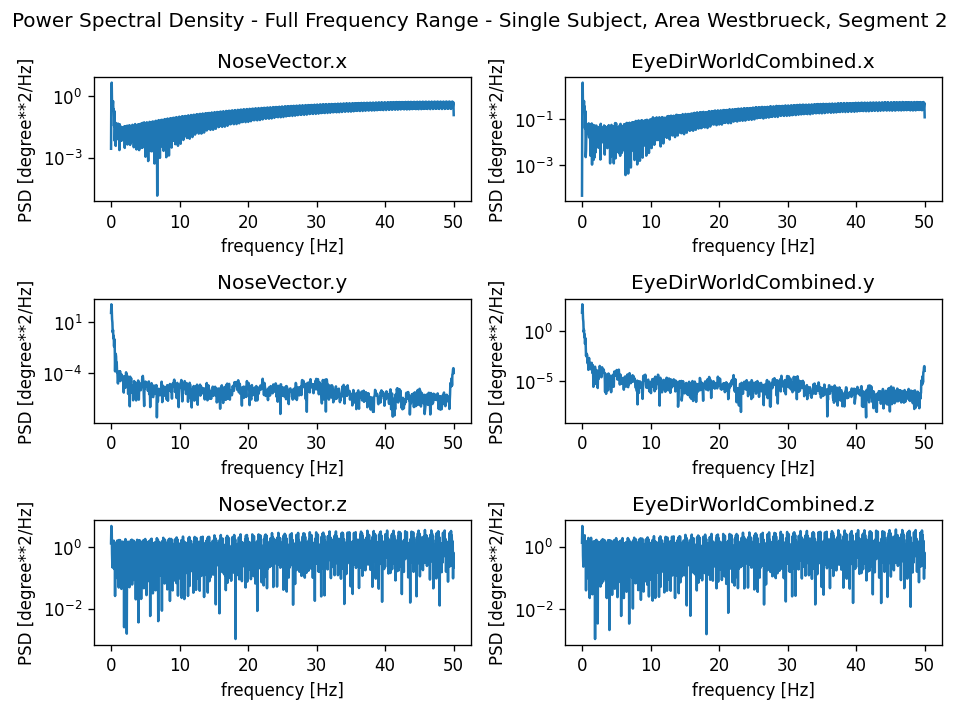

In [63]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]] - 180) % 360) - 180
    #x = one_participant_single_segment[names_x[idx]]
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

In [34]:
one_participant_single_segment

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z,resampled_timestamp,is_interpolated
0,28.588840,0.994293,15.093018,-0.845969,-239.021847,-0.463201,28.599136,0.993851,15.124634,-0.748357,-239.312828,-0.662741,0.01,False
1,0.325340,1.045746,-0.293945,-0.838421,-239.019824,-0.475601,0.343803,1.045029,-0.282349,-0.779746,-239.310993,-0.625587,0.02,False
2,0.325752,1.045898,-0.293091,-0.838429,-239.016766,-0.473863,0.348070,1.044571,-0.291260,-0.790387,-239.311305,-0.612057,0.03,False
3,0.325981,1.045898,-0.292603,-0.838533,-239.016013,-0.473249,0.349451,1.044434,-0.294556,-0.797913,-239.316404,-0.601999,0.04,False
4,0.326147,1.045853,-0.292236,-0.838799,-239.015991,-0.472763,0.349735,1.044510,-0.294067,-0.798480,-239.314599,-0.601335,0.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,0.103531,1.028610,-0.397339,-360.611136,-254.866552,-360.234284,0.120682,1.031647,-0.374207,-360.578676,-255.097836,-360.380527,29.28,True
2928,0.079498,1.028595,-0.404419,-360.607344,-254.702618,-360.235970,0.096939,1.031540,-0.383423,-360.575244,-254.934310,-360.380318,29.29,False
2929,0.078278,1.028595,-0.404663,-360.610354,-254.209223,-360.241444,0.096313,1.031448,-0.386597,-360.578401,-254.450540,-360.381883,29.30,False
2930,0.161636,1.028542,-0.377625,-360.597177,-253.719216,-360.241151,0.179596,1.031456,-0.358765,-360.564649,-253.959386,-360.381939,29.31,True


In [26]:
one_participant_single_segment['NoseVector.x'].min() - one_participant_single_segment['NoseVector.x'].max()

-360.23362727835774

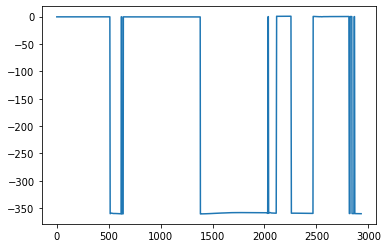

In [29]:
plt.plot(one_participant_single_segment['NoseVector.z'])#[:400])

-179.90115507806513

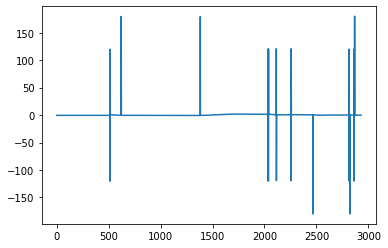

In [61]:
z_test = one_participant_single_segment['NoseVector.z'].copy()

z_test.max()
z_test.min() + z_test.max()
#plt.plot(z_test[z_test<-180] + 360)

z_test
#z_test = z_test+z_test.max()

plt.plot(((z_test - 180) % 360) - 180)

z_test_180 = ((z_test - 180) % 360) - 180

z_test_180.min()



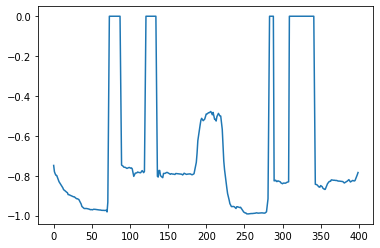

In [38]:
plt.plot(one_participant_single_segment['EyeDirWorldCombined.x'][:400])

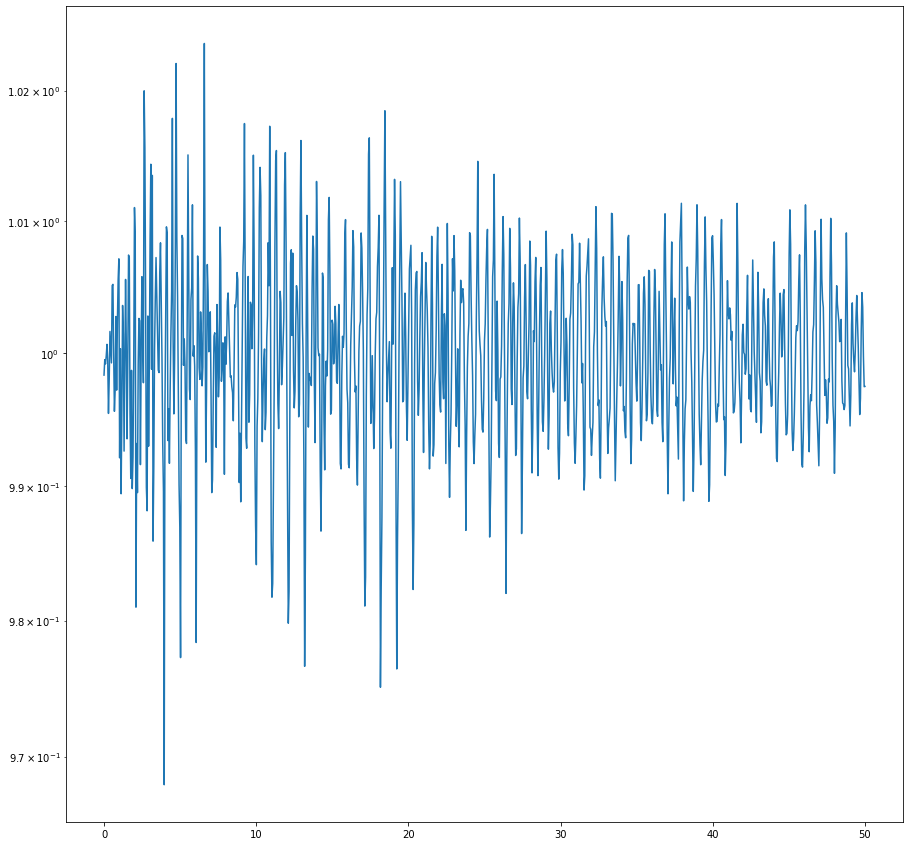

In [26]:
f_Nose, pxx_den_Nose = signal.welch(x=one_participant_single_segment['NoseVector.x'],fs=(1/0.01),nperseg=2048)
    
f_Eye, pxx_den_Eye = signal.welch(x=one_participant_single_segment['EyeDirWorldCombined.x'],fs=(1/0.01),nperseg=2048)


plt.figure(figsize=(15,15))

plt.semilogy(f, pxx_den_Nose/pxx_den_Eye) 




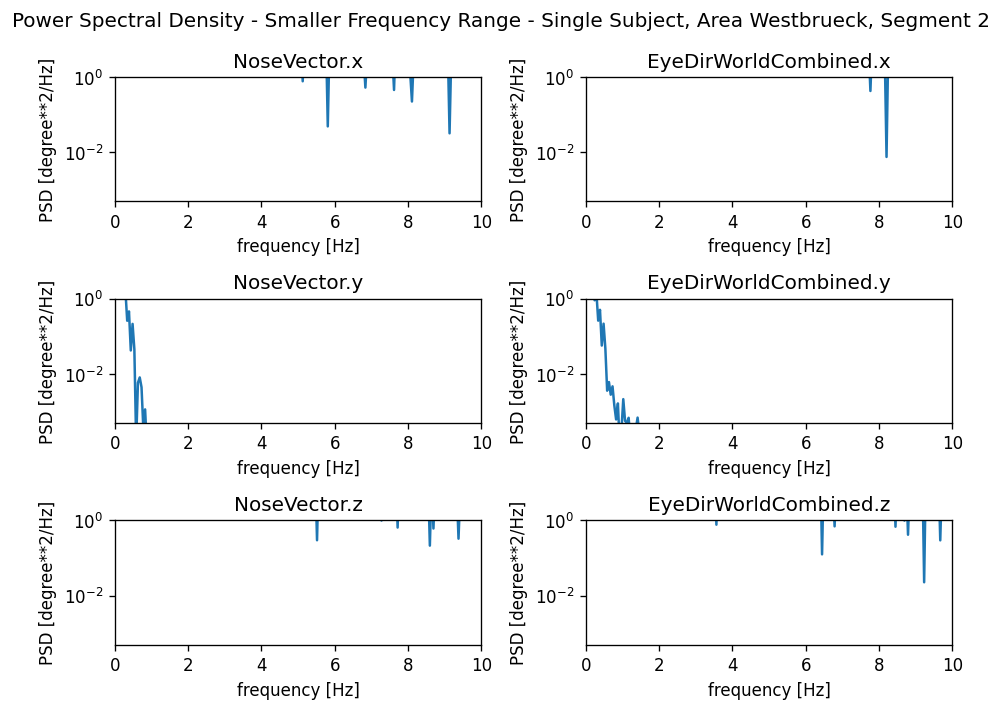

In [11]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    f, pxx_den = signal.welch(x=one_participant_single_segment[names_x[idx]],fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,10)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

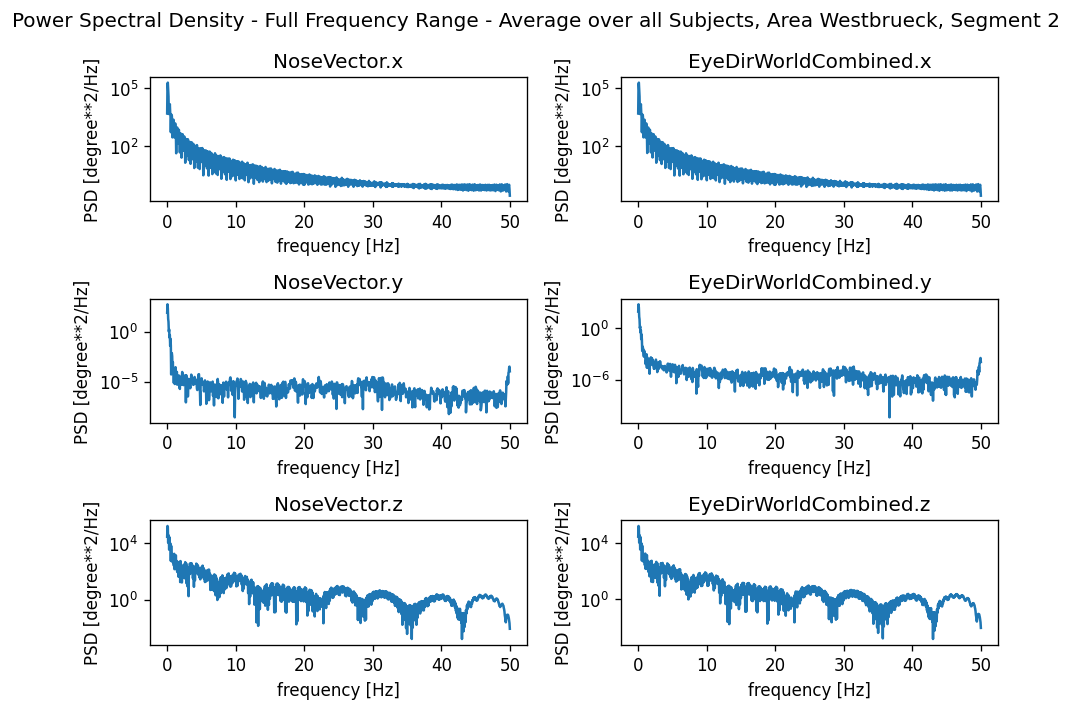

In [27]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    f, pxx_den = signal.welch(x=average_over_all_participants_single_segment[names_x[idx]],fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

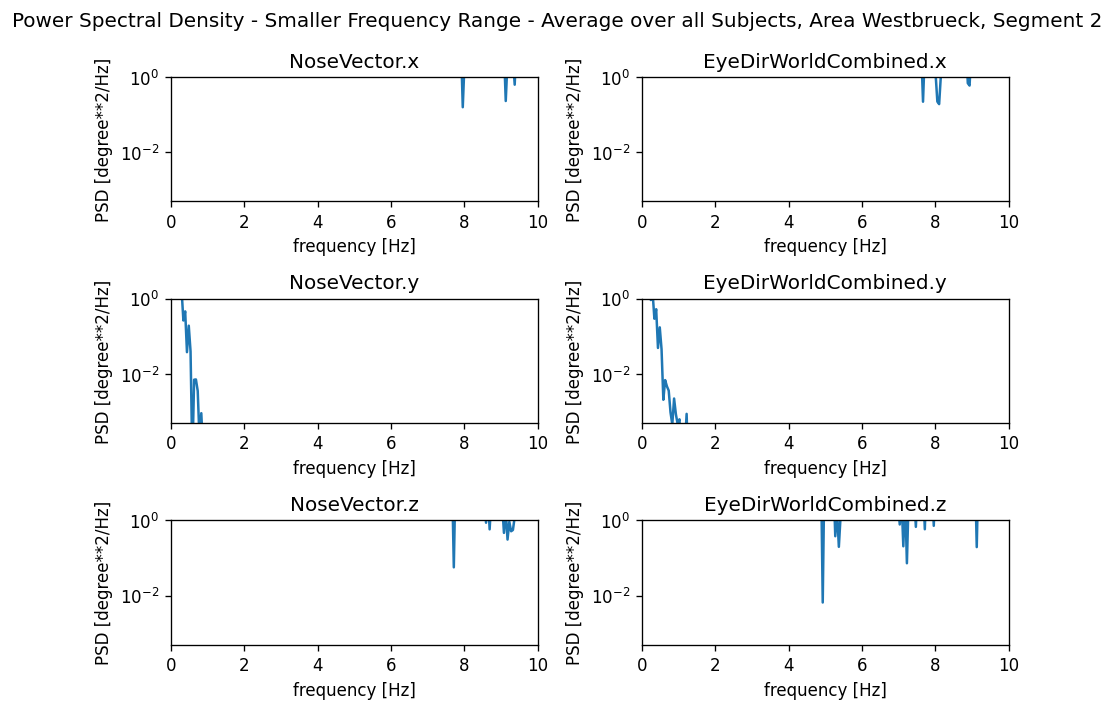

In [13]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    f, pxx_den = signal.welch(x=average_over_all_participants_single_segment[names_x[idx]],fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,10)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

## Cross spectral density

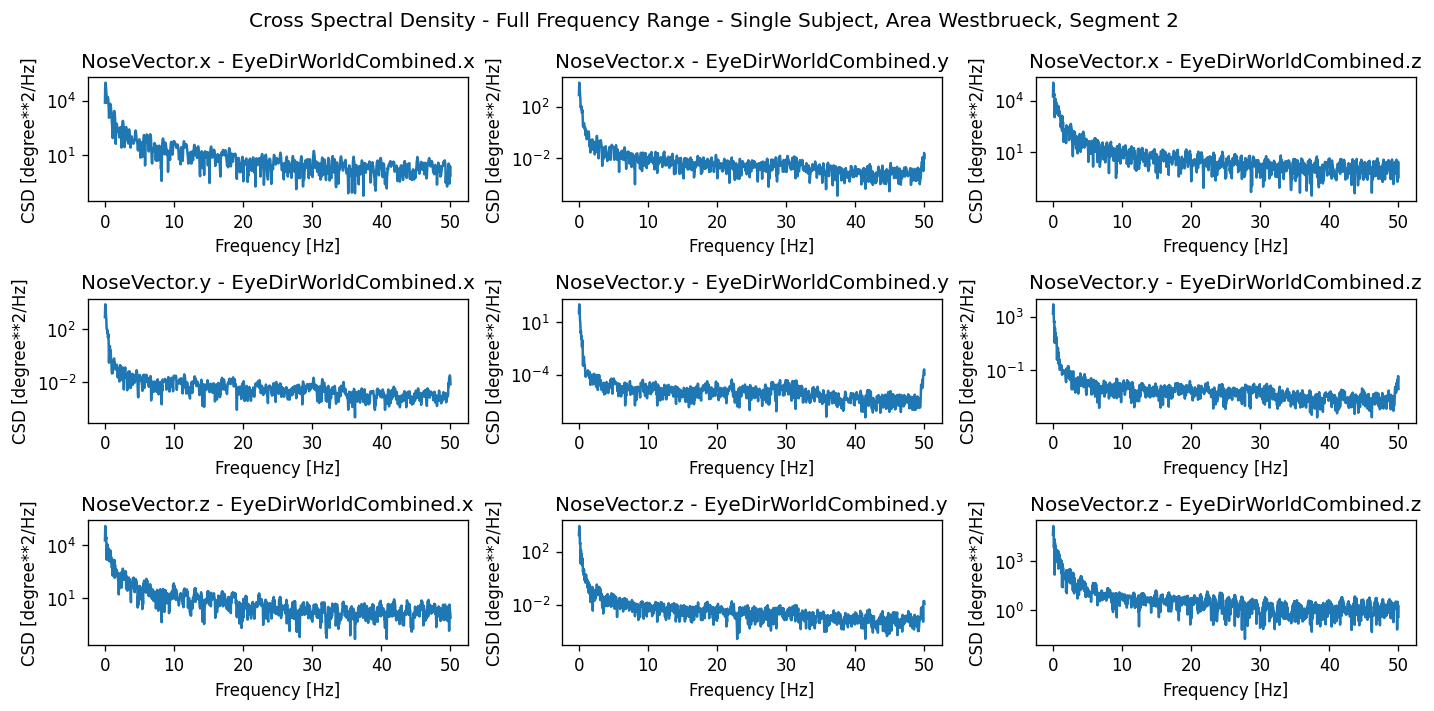

In [14]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        
        sample_freqs, csd = signal.csd(x=one_participant_single_segment[names_x[idx]],y=one_participant_single_segment[names_y[idx]],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

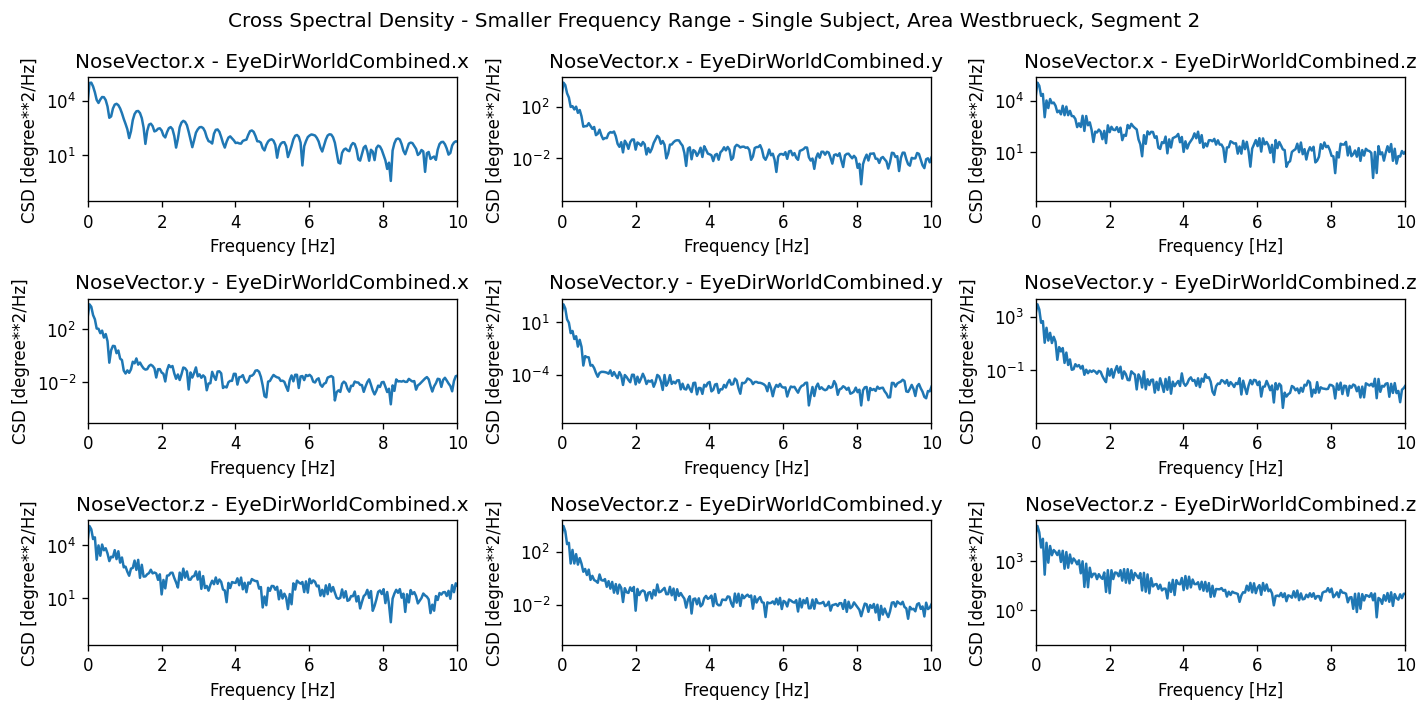

In [15]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        
        sample_freqs, csd = signal.csd(x=one_participant_single_segment[names_x[idx]],y=one_participant_single_segment[names_y[idx]],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

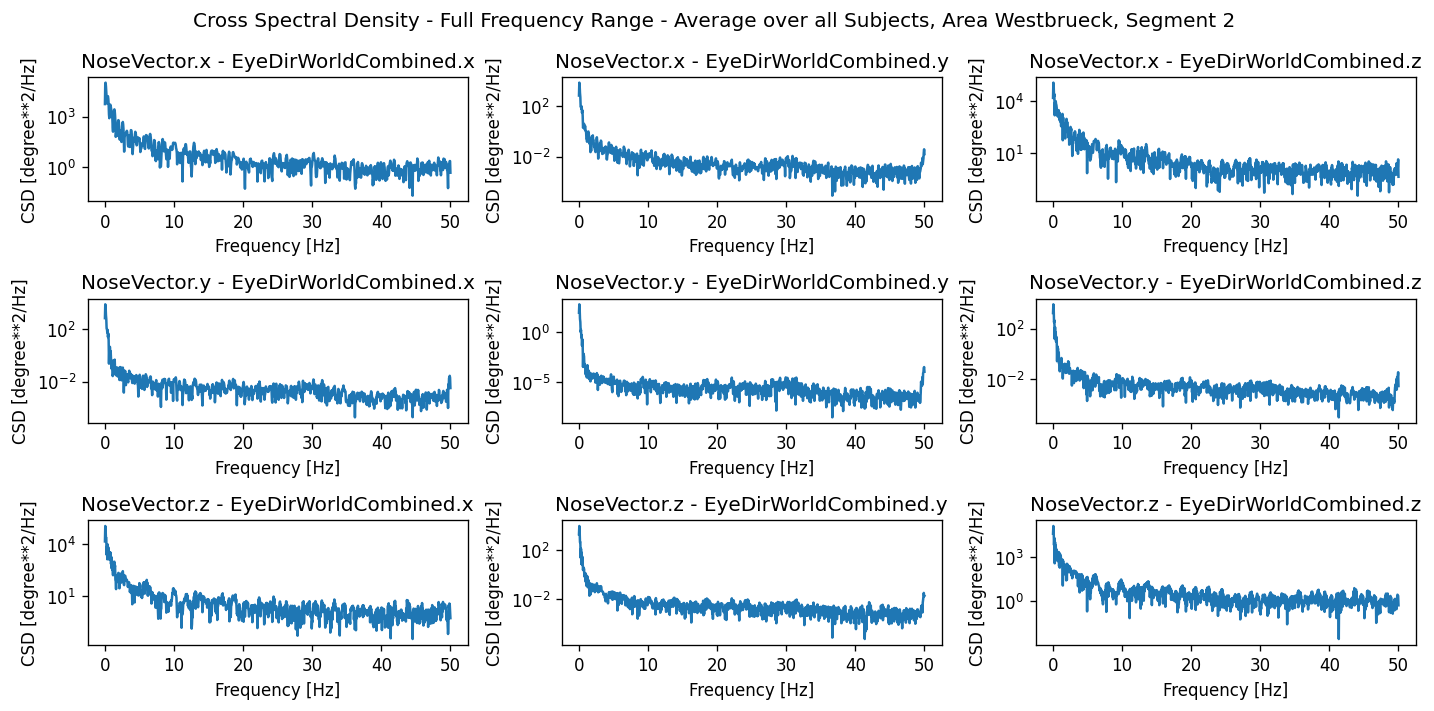

In [16]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        
        sample_freqs, csd = signal.csd(x=average_over_all_participants_single_segment[names_x[idx]],y=average_over_all_participants_single_segment[names_y[idx]],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

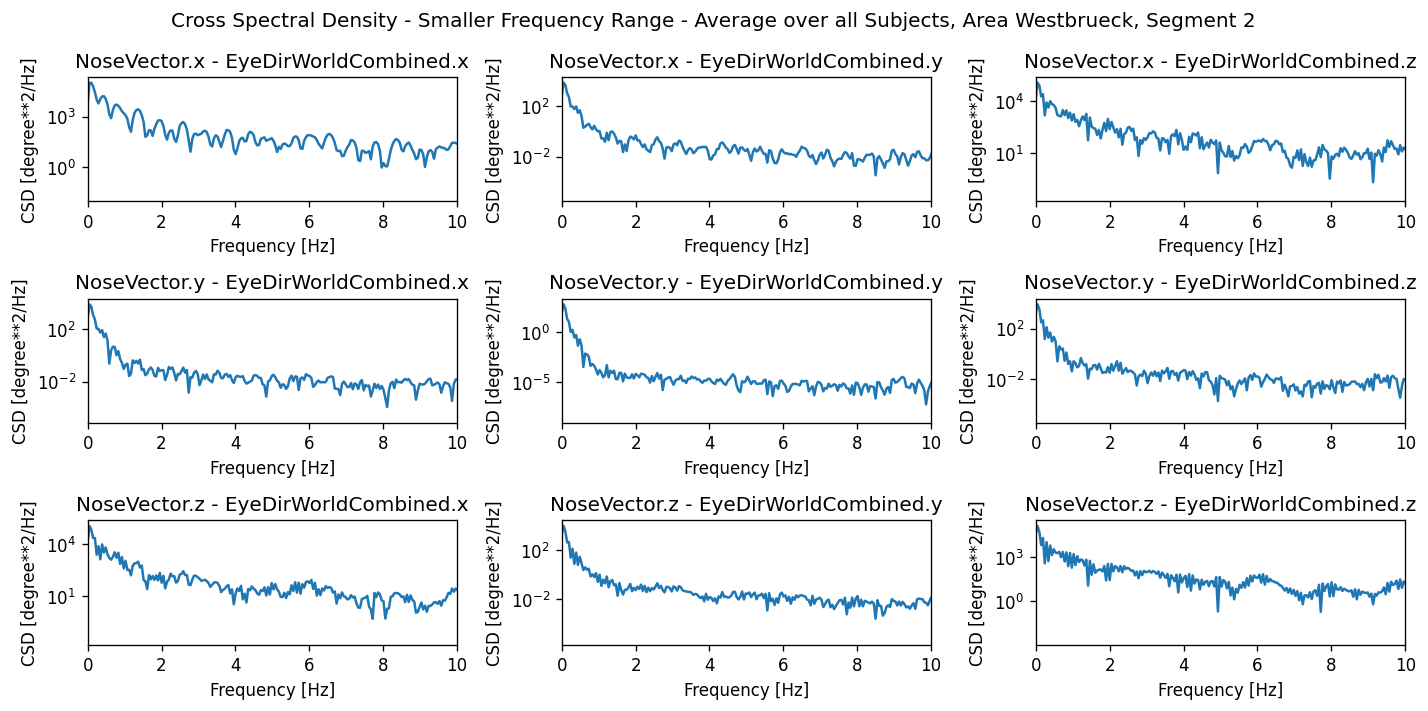

In [17]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        
        sample_freqs, csd = signal.csd(x=average_over_all_participants_single_segment[names_x[idx]],y=average_over_all_participants_single_segment[names_y[idx]],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()